In [53]:
# Data Loading and Preprocessing
import pandas as pd

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

merged_data = pd.merge(transactions, customers, on='CustomerID', how='left')

customer_transactions = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    unique_products=('ProductID', 'nunique')
).reset_index()

customer_profile = customers[['CustomerID', 'Region']]

clustering_data = pd.merge(customer_transactions, customer_profile, on='CustomerID', how='left')

clustering_data.head()

,CustomerID,total_spent,total_quantity,unique_products,Region
0,C0001,3354.52,12,5,South America
1,C0002,1862.74,10,4,Asia
2,C0003,2725.38,14,4,South America
3,C0004,5354.88,23,8,South America
4,C0005,2034.24,7,3,Asia


In [54]:
# Data Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data[['total_spent', 'total_quantity', 'unique_products']])

clustering_data_scaled[:5]

array([[-0.06170143, -0.12203296,  0.05004655],
       [-0.87774353, -0.44800021, -0.42420409],
       [-0.40585722,  0.20393428, -0.42420409],
       [ 1.03254704,  1.67078689,  1.47279848],
       [-0.78392861, -0.93695108, -0.89845473]])

In [55]:
# Clustering Using K-Means
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(clustering_data_scaled)

clustering_data['Cluster'] = kmeans.labels_
clustering_data[['CustomerID', 'Cluster']].head()

,CustomerID,Cluster
0,C0001,3
1,C0002,3
2,C0003,3
3,C0004,0
4,C0005,1


In [56]:
# Evaluating the Clustering
from sklearn.metrics import davies_bouldin_score

# Calculate the Davies-Bouldin index
db_index = davies_bouldin_score(clustering_data_scaled, clustering_data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 0.8956923630972515


In [57]:
cluster_sizes = np.bincount(kmeans.labels_)
print(f"Cluster Sizes: {cluster_sizes}")

avg_total_spend = clustering_data.groupby('Cluster')['total_spent'].mean()
print(f"Average Total Spend per Cluster: {avg_total_spend}")

avg_quantity = clustering_data.groupby('Cluster')['total_quantity'].mean()
print(f"Average Quantity Purchased per Cluster: {avg_quantity}")

    

Cluster Sizes: [27 41 51 80]
Average Total Spend per Cluster: Cluster
0    6438.814074
1    1270.239268
2    4511.044902
3    2925.056000
Name: total_spent, dtype: float64
Average Quantity Purchased per Cluster: Cluster
0    23.259259
1     5.097561
2    16.470588
3    10.750000
Name: total_quantity, dtype: float64


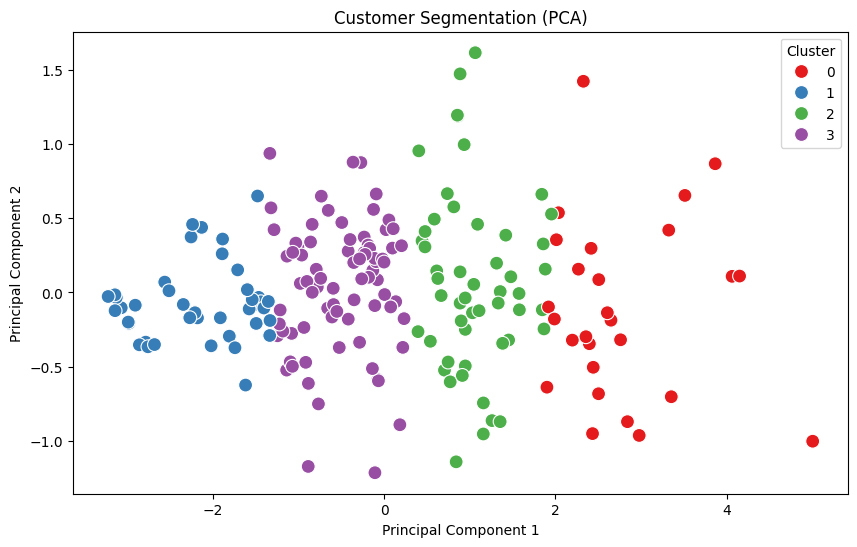

In [58]:
# Visualizing the Clusters
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(clustering_data_scaled)

pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clustering_data['Cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100)
plt.title('Customer Segmentation (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [59]:
# Summary of Clustering Results
cluster_summary = clustering_data.groupby('Cluster').agg(
    cluster_size=('CustomerID', 'count'),
    avg_total_spent=('total_spent', 'mean'),
    avg_total_quantity=('total_quantity', 'mean'),
    avg_unique_products=('unique_products', 'mean')
).reset_index()

cluster_summary

,Cluster,cluster_size,avg_total_spent,avg_total_quantity,avg_unique_products
0,0,27,6438.814074,23.259259,7.962963
1,1,41,1270.239268,5.097561,2.170732
2,2,51,4511.044902,16.470588,6.294118
3,3,80,2925.056000,10.750000,4.362500
